# Goal

> Based on https://arxiv.org/pdf/2310.10165

We want to optimise the probability of quantum tunneling.

1. Define the Hilbert Space
2. Define the Hamiltonian
3. Define the Operators
4. WIP: Take the partial trace over
5. Optimize the parameters

# Structure of the paper

## Trapped two-mode bosonic systems

We have a double well-trap described by

## Noiseless coupling to ancilla systems

## Two simple limit cases

## Decoherence

## Numerics for a 1-boson system

## Multi-particle noiseless tunneling and physical resources

## Decoherence: a proof of concept

## Outlook

# Auxiliary functions

In [ ]:
from scipy.linalg import expm
from src import visualization
import numpy as np
import torch

In [2]:
def generate_jz(n):
    return np.diag([(n - 2*k)*.5 for k in range(n+1)])

In [3]:
def generate_hamiltonian(
    eta_s : float = 0,
    gamma_s: float = 0,
    delta_s: float = 0,
    total_n: int = 1
) -> np.array:
    Jz = generate_jz(total_n)
    Jz_squared = Jz**2
    
    Jx = np.zeros((total_n+1, total_n+1))
    for k in range(total_n): # DOUBLE CHECK WITH NIKITA
        Jx[k+1,k] = np.sqrt((k+1)*(total_n-k))
        Jx[k,k+1] = np.sqrt((k+1)*(total_n-k))

    return np.sum(
        [
            eta_s * Jz_squared, # eta_s * J_z^2
            -1 * gamma_s * Jx, # - gamma_s * J_x
            -1 * delta_s * Jz# -delta_s * J_z
        ], axis=0 # Sum the matrices elementwise
    )

In [4]:
def generate_coupled_hamiltonian(
    eta_s : float = 0,
    gamma_s: float = 0,
    delta_s: float = 0,
    total_n: int = 1,
    eta_anc : float = 0,
    gamma_anc: float = 0,
    delta_anc: float = 0,
    total_n_anc: int = 1,
    alpha : float = 0
):
    system_hamiltonian = generate_hamiltonian(eta_s, gamma_s,delta_s,total_n)
    ancillary_hamiltonian = generate_hamiltonian(eta_anc, gamma_anc,delta_anc,total_n_anc)
    
    return np.sum(
        [
            np.kron(system_hamiltonian, np.identity(total_n_anc+1)), # H_S X 1
            np.kron( np.identity(total_n+1), ancillary_hamiltonian), # 1 X H_A
            alpha * np.kron(generate_jz(total_n), generate_jz(total_n_anc)) # J_z X J_z
        ],
        axis=0
    )

In [5]:
def full_plot(
    eta_s : float = 0,
    gamma_s: float = 0,
    delta_s: float = 0,
    total_n: int = 1
):
    initial_state = [1] + [0 for _ in range(total_n)]
    visualization.finite_dimensional_populations_over_time(
        hamiltonian=generate_hamiltonian(eta_s=eta_s, gamma_s=gamma_s,delta_s=delta_s,total_n=total_n),
        rho0=np.outer(initial_state, initial_state),
    )

In [6]:
generate_hamiltonian(eta_s=1, gamma_s=2,delta_s=3,total_n=4)

array([[-2.        , -4.        ,  0.        ,  0.        ,  0.        ],
       [-4.        , -2.        , -4.89897949,  0.        ,  0.        ],
       [ 0.        , -4.89897949,  0.        , -4.89897949,  0.        ],
       [ 0.        ,  0.        , -4.89897949,  4.        , -4.        ],
       [ 0.        ,  0.        ,  0.        , -4.        , 10.        ]])

In [7]:
v = np.array([1,0,0,0,0])
np.outer(v,v)

array([[1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

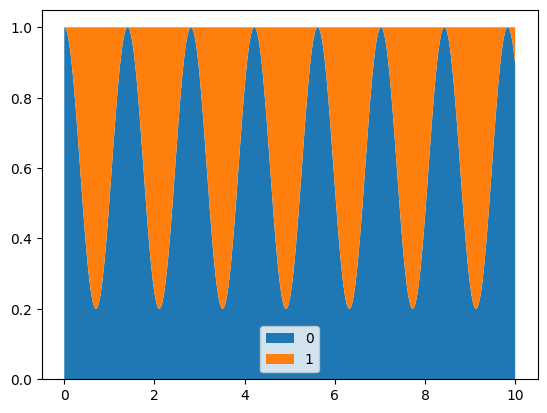

In [8]:
full_plot(eta_s=1, gamma_s=2,delta_s=2,total_n=1)

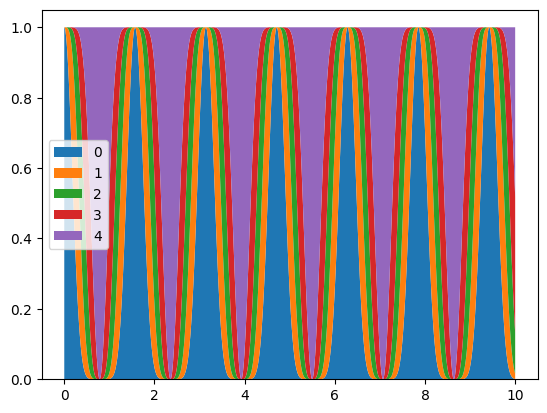

In [9]:
full_plot(eta_s=0, gamma_s=2,delta_s=0,total_n=4)

# Visualize state evolution

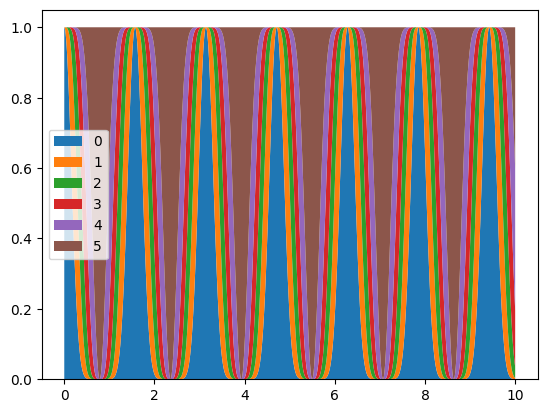

In [10]:
full_plot(eta_s=0, gamma_s=2,delta_s=0,total_n=5)

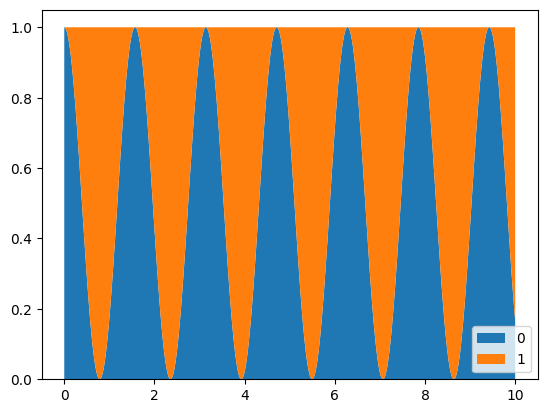

In [11]:
full_plot(eta_s=0, gamma_s=2,delta_s=0,total_n=1)

In [14]:
generate_coupled_hamiltonian()

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# Paper's optimization

Loss function = $\mathrm{Tr}[\rho_R^S\rho_L^S(t)]$, based on https://arxiv.org/pdf/2310.10165#page=13

In [84]:
def loss_function(
    time: float,
    eta_s : float = 0,
    gamma_s: float = 0,
    delta_s: float = 0,
    total_n: int = 1,
    eta_anc : float = 0,
    gamma_anc: float = 0,
    delta_anc: float = 0,
    total_n_anc: int = 1,
    alpha : float = 0,
):

    hamiltonian = generate_coupled_hamiltonian(eta_s, gamma_s, delta_s, total_n, eta_anc, gamma_anc, delta_anc, total_n_anc, alpha)
    phi_right = np.kron(
        list(np.zeros(total_n-1)) + [1],
        list(np.zeros(total_n_anc-1)) + [1],
    )
    rho_right = np.einsum('i,j->ij', phi_right, phi_right)
    print(expm(-1j * hamiltonian * time).shape)
    print(phi_right)
    print(rho_right)
    rho_left_t = expm(-1j * hamiltonian * time) @ rho_right @ expm(1j * hamiltonian * time)
    rho_system_right = rho_right.reshape((total_n, total_n_anc)).sum(axis=1)
    rho_system_left_t = rho_left_t.reshape((total_n, total_n_anc)).sum(axis=1)
    full_trace = np.einsum(
        'ii',
        rho_system_right @ rho_system_left_t
    )
    return full_trace

In [85]:
temp = np.kron(
    list(np.zeros(1)) + [1],
    list(np.zeros(5)) + [1],
)
np.einsum('i,j->ij', temp, temp)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [90]:
parameters = torch.tensor([
        0., # eta_anc : float = 0,
        0., # gamma_anc: float = 0,
        0., # delta_anc: float = 0,
        2., # total_n_anc: int = 1,
        0., #  alpha : float = 0,
        1., # time
    ],
    requires_grad=True).to(dtype=torch.long)
optimizer = torch.optim.Adam([parameters], lr=.01, differentiable=False)

for _ in range(1000):
    loss = loss_function(
        time=1,
        eta_s= 0,
        gamma_s = 0,
        delta_s = 0,
        total_n = 2,
        eta_anc = parameters[0],
        gamma_anc = parameters[1],
        delta_anc = parameters[2],
        total_n_anc = parameters[3],
        alpha = parameters[4],
)
    optimizer.zero_grad
    loss.backward()
    optimizer.step()

(9, 9)
[0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


ValueError: cannot reshape array of size 81 into shape (2,2)

# Layout of the paper

Single boson system:
- Bose-Hubbard hamiltonian: $H_S = \eta_S J_z^2 - \gamma_S J_x - \Delta_S J_z$
- Left to right probability of jump: $\mathbb{P}_{L \rightarrow R}[t] = \mathrm{T}[\rho_L(t) \rho_R] = \braket{0 | \rho_L | 0 }$
- Time evolution: $\rho_L(t) = \exp \left ( - \frac{i}{\hbar} H_S t \right ) \rho_L \left ( + \frac{i}{\hbar} H_S t \right )$

Two-level system:
- The hamiltonian reduces to: $H_S = - \Delta \sigma_z - \gamma \sigma_x$. $J_z^2 = \frac{1}{4}\sigma_z^2 = \frac{I}{4}$ can be neglected.
- $\mathbb{P}_{L \rightarrow R}[t] = \frac{\gamma^2}{\hbar^2 \omega^2} \sin^2(\omega t)$, where $\hbar \omega = \sqrt{\Delta^2 + \gamma^2}$

Assymetric level system with 

# QuTip approach

In [1]:
from qutip.core import tensor, basis, spin_Jz

In [2]:
tensor(basis(2,0), basis(3,2))

Quantum object: dims=[[2, 3], [1, 1]], shape=(6, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

In [7]:
spin_Jz(.5)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]

In [ ]:
def generate_transition(current_value):
    return current_value + np.random(1) # replace with your actual transition

trajectory = [3] # replace 3 with your initial value
for _ in range(1000):
    trajectory.append(generate_transition(trajectory[-1]))